In [116]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns
import os

from sklearn.datasets import fetch_covtype, load_iris
import torchvision
import torchvision.transforms as transforms
import torch

from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from baselineClassifierNN import SimpleMLP
from DynamicClassifierNN import DynamicMLP

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from itertools import product
import json
from training import train_complex_model, train_model, plot_learning_curves
import random
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
seed = 42

Using device: cpu


In [117]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
rcParams['axes.labelsize'] = 12  # Academic font size for axis labels
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['axes.titlesize'] = 14
figsize = (8, 6) 

In [118]:
data_dir = "../data"
results_dir = "../results"

In [119]:
random.seed(seed)  # Set seed for Python's random module
np.random.seed(seed)  # Set seed for NumPy
torch.manual_seed(seed)  # Set seed for PyTorch (CPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)  # Set seed for CUDA (single GPU)
    torch.cuda.manual_seed_all(seed)  # Set seed for CUDA (all GPUs)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
torch.backends.cudnn.benchmark = False

# Get datasets section

In [120]:
iris = load_iris()

X = iris.data  
y = iris.target    
df_iris = pd.DataFrame(X, columns=iris.feature_names)
df_iris['label'] = y
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [121]:
# Split iris dataset so that 50 observations go to train, validation, and test each (total 150 entries)
df_iris_shuffled = df_iris.sample(frac=1, random_state=42).reset_index(drop=True)
df_iris_train = df_iris_shuffled.iloc[:100].copy()
df_iris_validation = df_iris_shuffled.iloc[100:125].copy()
df_iris_test = df_iris_shuffled.iloc[125:150].copy()

print("Train shape:", df_iris_train.shape)
print("Validation shape:", df_iris_validation.shape)
print("Test shape:", df_iris_test.shape)
df_iris_train

Train shape: (100, 5)
Validation shape: (25, 5)
Test shape: (25, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1
...,...,...,...,...,...
95,5.5,2.5,4.0,1.3,1
96,4.4,2.9,1.4,0.2,0
97,4.3,3.0,1.1,0.1,0
98,6.0,2.2,5.0,1.5,2


### Fashion-MNIST dataset

In [122]:

# Download and load Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True,  
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Convert train_dataset to DataFrame
train_images = []
train_labels = []

for img, label in train_dataset:
    train_images.append(img.numpy().flatten())
    train_labels.append(label)

df_train_fashion = pd.DataFrame(train_images)
df_train_fashion['label'] = train_labels

# Convert test_dataset to DataFrame
test_images = []
test_labels = []

for img, label in test_dataset:
    test_images.append(img.numpy().flatten())
    test_labels.append(label)

df_test_fashion = pd.DataFrame(test_images)
df_test_fashion['label'] = test_labels

print("Fashion-MNIST dataset loaded.")
print(f"Fashion-MNIST train shape: {df_train_fashion.shape}, Fashion-MNIST test shape: {df_test_fashion.shape}")
df_train_fashion.head()


Fashion-MNIST dataset loaded.
Fashion-MNIST train shape: (60000, 785), Fashion-MNIST test shape: (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [123]:
df_train_fashion.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.000003,0.000023,0.000118,0.000407,0.000979,0.001626,0.003222,0.008724,0.022348,0.056606,...,0.091014,0.065005,0.069929,0.089878,0.070262,0.033277,0.010613,0.003212,0.000278,4.500000
std,0.000363,0.000977,0.003011,0.009851,0.016986,0.022853,0.032588,0.055693,0.093474,0.149822,...,0.191692,0.164880,0.172201,0.203641,0.177152,0.115485,0.067681,0.035817,0.008141,2.872305
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.031373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,0.062745,0.141176,0.466667,0.643137,0.878431,0.901961,0.866667,0.866667,0.996078,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,9.000000


In [124]:
# what is the class distribution for each dataset
print("Iris class distribution:\n", pd.Series(df_iris_train['label']).value_counts().sort_index())
print("Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Iris class distribution:
 label
0    37
1    32
2    31
Name: count, dtype: int64
Fashion-MNIST class distribution:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


In [1]:
# Take 10 entries away from class 1 and 2 in train and validation, and put them in test
for cls in [1, 2]:
    # For train set
    idx_train = df_iris_train[df_iris_train['label'] == cls].index[:10+cls]
    rows_to_move_train = df_iris_train.loc[idx_train]
    df_iris_train = df_iris_train.drop(idx_train)
    df_iris_test = pd.concat([df_iris_test, rows_to_move_train], ignore_index=True)
    
    # For validation set
    idx_val = df_iris_validation[df_iris_validation['label'] == cls].index[:2+cls]
    rows_to_move_val = df_iris_validation.loc[idx_val]
    df_iris_validation = df_iris_validation.drop(idx_val)
    df_iris_test = pd.concat([df_iris_test, rows_to_move_val], ignore_index=True)
print("Updated train Iris class distribution:\n", pd.Series(df_iris_train['label']).value_counts().sort_index())
print("Updated val Iris class distribution:\n", pd.Series(df_iris_validation['label']).value_counts().sort_index())
print("Updated test Iris class distribution:\n", pd.Series(df_iris_test['label']).value_counts().sort_index())

NameError: name 'df_iris_train' is not defined

In [46]:
# take away 1000 entries from class label 0 in fashion mnist
for i in range(0, 10):
    index_to_drop = df_train_fashion[df_train_fashion['label'] == i].index[0]
    df_train_fashion = df_train_fashion.drop(df_train_fashion[df_train_fashion['label'] == i].index[:500*i])
print("Updated Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Updated Fashion-MNIST class distribution:
 label
0    6000
1    5500
2    5000
3    4500
4    4000
5    3500
6    3000
7    2500
8    2000
9    1500
Name: count, dtype: int64


### Prepare each dataset for training and testing

In [72]:
# assign a stable orig_uid to each source DataFrame row so we can detect overlap when concatenating later
def ensure_orig_uid(df):
    if 'orig_uid' not in df.columns:
        df = df.reset_index(drop=True).copy()
    return df

## Iris dataset

In [126]:
X_train_iris_init = df_iris_train.drop('label', axis=1)
y_train_iris = df_iris_train['label']


X_val_iris_init = df_iris_validation.drop('label', axis=1)
y_val_iris = df_iris_validation['label']

X_test_iris_init = df_iris_test.drop('label', axis=1)
y_test_iris = df_iris_test['label']


In [127]:
dfs_iris_all_train =  [ensure_orig_uid(df_iris_train[df_iris_train['label'] == i].reset_index(drop=True)) for i in range(3)]

dfs_iris_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_iris = [df['label'].iloc[0] for df in dfs_iris_all_train]
range_iris = range(0, len(sorted_label_order_iris))
label_map_iris = dict(zip(sorted_label_order_iris, range_iris))

print(f"label order map for iris: {label_map_iris}")
# assign the value from the map to the train and test set label
dfs_iris_all_train = [df.assign(label=label_map_iris[df['label'].iloc[0]]) for df in dfs_iris_all_train]
dfs_iris_all_validation = [df_iris_validation[df_iris_validation['label'] == lbl].assign(label=label_map_iris[lbl]) for lbl in sorted_label_order_iris]
dfs_iris_all_test = [df_iris_test[df_iris_test['label'] == lbl].assign(label=label_map_iris[lbl]) for lbl in sorted_label_order_iris]

print("DataFrames sorted by class size.")
print(f"Size of each class in Iris train: {[len(df) for df in dfs_iris_all_train]}")
print(f"Label for iris order: {sorted_label_order_iris}")
print(f"Example entries from class 1 train:\n{dfs_iris_all_train[0].head()} and class 1 test:\n{dfs_iris_all_validation[0].head()}")
print(f"Example entries from class 2 train:\n{dfs_iris_all_train[2].head()} and class 2 test:\n{dfs_iris_all_validation[2].head()}")

label order map for iris: {np.int64(2): 0, np.int64(1): 1, np.int64(0): 2}
DataFrames sorted by class size.
Size of each class in Iris train: [19, 21, 37]
Label for iris order: [np.int64(2), np.int64(1), np.int64(0)]
Example entries from class 1 train:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.8               2.7                5.1               1.9   
1                6.3               2.8                5.1               1.5   
2                6.4               3.1                5.5               1.8   
3                7.2               3.6                6.1               2.5   
4                7.6               3.0                6.6               2.1   

   label  
0      0  
1      0  
2      0  
3      0  
4      0   and class 1 test:
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
113                6.4               3.2                5.3               2.3   
115                6.9    

In [128]:
# Remap y_train_iris and y_test_iris to match sorted_label_order_iris
label_map_iris = dict(zip(sorted_label_order_iris, range(len(sorted_label_order_iris))))
y_train_iris = y_train_iris.map(label_map_iris)
y_test_iris = y_test_iris.map(label_map_iris)
y_val_iris = y_val_iris.map(label_map_iris)

X_train_iris = torch.tensor(X_train_iris_init.values, dtype=torch.float32).to(device)
y_train_iris = torch.tensor(y_train_iris.values, dtype=torch.long).to(device)
X_val_iris = torch.tensor(X_val_iris_init.values, dtype=torch.float32).to(device)
y_val_iris = torch.tensor(y_val_iris.values, dtype=torch.long).to(device)
X_test_iris = torch.tensor(X_test_iris_init.values, dtype=torch.float32).to(device)
y_test_iris = torch.tensor(y_test_iris.values, dtype=torch.long).to(device)

### Fashion-MNIST dataset

In [34]:
X_train_fashion_init = df_train_fashion.drop('label', axis=1)
y_train_fashion = df_train_fashion['label']

X_train_fashion_final, X_validation_fashion_final, y_train_fashion_final, y_validation_fashion_final = train_test_split(X_train_fashion_init, y_train_fashion, test_size=0.3, random_state=42)

X_test_fashion_init = df_test_fashion.drop('label', axis=1)
y_test_fashion = df_test_fashion['label']


In [17]:
# dfs_fashion_all_train = [ensure_orig_uid(df_train_fashion[df_train_fashion['label'] == i].reset_index(drop=True)) for i in range(10)]

# # Split Fashion-MNIST train set into train and validation (30% validation)
# df_train_fashion = df_train_fashion.copy()
# df_fashion_validation = df_train_fashion.sample(frac=0.3, random_state=42)
# df_train_fashion = df_train_fashion.drop(index=df_fashion_validation.index).reset_index(drop=True)
# df_fashion_validation = df_fashion_validation.reset_index(drop=True)
# df_test_fashion = df_test_fashion.reset_index(drop=True)
# print(f"Fashion-MNIST validation shape: {df_fashion_validation.shape}, test shape: {df_test_fashion.shape}")

# # sort the dataframes list by the size of each dataframe in ascending order
# # Ensure orig_uid present for fashion class dfs
# dfs_fashion_all_train = [ensure_orig_uid(df) for df in dfs_fashion_all_train]
# dfs_fashion_all_train.sort(key=lambda x: len(x), reverse=False)
# sorted_label_order_fashion = [df['label'].iloc[0] for df in dfs_fashion_all_train]
# range_fashion = range(0, len(sorted_label_order_fashion))
# label_map_fashion = dict(zip(sorted_label_order_fashion, range_fashion))

# print(f"label order map for fashion: {label_map_fashion}")
# # assign the value from the map to the train and test set label
# dfs_fashion_all_train = [df.assign(label=label_map_fashion[df['label'].iloc[0]]) for df in dfs_fashion_all_train]
# dfs_fashion_all_validation = [df_fashion_validation[df_fashion_validation['label'] == lbl].assign(label=label_map_fashion[lbl]) for lbl in sorted_label_order_fashion]
# dfs_fashion_all_test = [df_test_fashion[df_test_fashion['label'] == lbl].assign(label=label_map_fashion[lbl]) for lbl in sorted_label_order_fashion]

# # Take a 10% sample from each class DataFrame in dfs_fashion_all_train and validation
# dfs_fashion_all_train_sample = [df.sample(frac=0.1, random_state=seed).reset_index(drop=True) for df in dfs_fashion_all_train]
# dfs_fashion_all_validation_sample = [df.sample(frac=0.1, random_state=seed).reset_index(drop=True) for df in dfs_fashion_all_validation]

# print("DataFrames sorted by class size.")
# print(f"Size of each class in Fashion MNIST train: {[len(df) for df in dfs_fashion_all_train]}")
# print(f"Label for fashion order: {sorted_label_order_fashion}")
# print("Number of labels in each class DataFrame (Fashion train):", [len(df['label']) for df in dfs_fashion_all_train])
# print("Sampled sizes for each class in Fashion train:", [len(df) for df in dfs_fashion_all_train_sample])
# print("Number of labels in Validation class DataFrames (Fashion):", [len(df['label']) for df in dfs_fashion_all_validation])
# print("Sampled sizes for each class in Fashion validation:", [len(df) for df in dfs_fashion_all_validation_sample])
# print(f"First entry of train: {dfs_fashion_all_train_sample[0].head(1)}")


In [18]:
# # Remap y_train_fashion_final, y_validation_fashion_final, and y_test_fashion to match sorted_label_order_fashion
# label_map_fashion = dict(zip(sorted_label_order_fashion, range(len(sorted_label_order_fashion))))
# y_train_fashion_final = y_train_fashion_final.map(label_map_fashion)
# y_validation_fashion_final = y_validation_fashion_final.map(label_map_fashion)
# y_test_fashion = y_test_fashion.map(label_map_fashion)
# X_train_fashion = torch.tensor(X_train_fashion_final.values, dtype=torch.float32).to(device)
# y_train_fashion = torch.tensor(y_train_fashion_final.values, dtype=torch.long).to(device)
# X_validation_fashion = torch.tensor(X_validation_fashion_final.values, dtype=torch.float32).to(device)
# y_validation_fashion = torch.tensor(y_validation_fashion_final.values, dtype=torch.long).to(device)
# X_test_fashion = torch.tensor(X_test_fashion_init.values, dtype=torch.float32).to(device)
# y_test_fashion = torch.tensor(y_test_fashion.values, dtype=torch.long).to(device)

### train baseline model

In [76]:
# 'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64), (150, 100, 50, 25)]
param_grid = {
    'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64), (512, 512, 512),
        (200, 150, 100, 50),
        (256, 128, 64, 32),     
        (512, 256, 128, 64),  
        (128, 128, 128, 128),     
        (300, 200, 100, 50),  ],
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [300]
}
param_grid_iris = {
    'hidden_layers': [(1,), (2,), (4,), (8,), (1, 1), (2, 2), (1, 2),(2,4) ],
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [50]
}
dynamic_param_grid = {
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [1000],
    'ma_window' :  30,
    'plateau_threshold' : 1e-4,
    'underfit_threshold' : 0.4,
    'over_fit_threshold_training' :  0.1,
    'over_fit_threshold_validation' : 0.1,
    'min_neurons' : 16,
    'max_layers': 3
}
dynamic_iris_param_grid = {
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'ma_window' :  [1, 2, 3, 5, 10, 20],
    'plateau_threshold' : [0.004],
    'underfit_threshold' : [0.1, 0.2, 0.3, 0.4],
    'over_fit_threshold_training' :  [0.1, 0.2],
    'over_fit_threshold_validation' : [0.1, 0.2],
    'min_neurons' : [1, 2, 4, 8],
    'max_layers': [1,2,3]
}

In [77]:
from tqdm import tqdm

def grid_search_params(X_train, y_train, X_test, y_test, param_grid):
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train))

    results = []

    for hidden_layers, activation, lr, epochs in product(
        param_grid['hidden_layers'],
        param_grid['activation'],
        param_grid['lr'],
        param_grid['epochs']
    ):
        model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr) if activation == 'relu' else optim.SGD(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_test).argmax(dim=1)
            acc = accuracy_score(y_test.cpu(), preds.cpu())
        results.append({
            'hidden_layers': hidden_layers,
            'activation': activation,
            'lr': lr,
            'epochs': epochs,
            'accuracy': acc
        })

    # Display top 5 results
    results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
    return results_df


def grid_search_dynamic_params(
    all_train_dfs, all_val_dfs, input_dim, param_grid, label='label', epochs=1000, runs=3, device=device, debug=False
):
    """
    Cross-validated grid search for dynamic model optimal parameters.
    Returns a DataFrame of results sorted by validation accuracy.
    """

    param_combinations = list(product(
        param_grid['activation'],
        param_grid['lr'],
        param_grid['ma_window'],
        param_grid['plateau_threshold'],
        param_grid['underfit_threshold'],
        param_grid['over_fit_threshold_training'],
        param_grid['over_fit_threshold_validation'],
        param_grid['min_neurons'],
    ))
    all_max_layers = param_grid.get('max_layers')
    print(f"Max layers to try: {all_max_layers}")
    results = []
    output_dim = len(all_train_dfs)
    for params in tqdm(param_combinations, desc="Grid Search CV"):
        param_dict = dict(zip(param_grid.keys(), params))
        val_accs = []
        for layer in all_max_layers:
            for run in range(runs):
                torch.manual_seed(42 + run)
                model = DynamicMLP(input_dim, max_layers=layer, debug=debug).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=param_dict['lr'])
                criterion = nn.CrossEntropyLoss()
                train_acc, val_acc, *_ = train_complex_model(
                    model, optimizer, criterion, param_dict, all_train_dfs, all_val_dfs, label=label, epochs=epochs, debug=debug
                )
                val_accs.append(val_acc[-1] if isinstance(val_acc, list) else val_acc)
            avg_val_acc = np.mean(val_accs)
            std_val_acc = np.std(val_accs)
            result = param_dict.copy()
            result['val_acc_mean'] = avg_val_acc
            result['val_acc_std'] = std_val_acc
            results.append(result)
    results_df = pd.DataFrame(results).sort_values('val_acc_mean', ascending=False)
    print(results_df.head())
    return results_df

In [21]:
# fashion_baseline_best_configs = grid_search_params(X_train_fashion, y_train_fashion, X_validation_fashion, y_validation_fashion, param_grid)
# fashion_baseline_best_configs.to_csv(os.path.join(results_dir, "fashion_baseline_best_configs.csv"), index=False)
# print("Fashion-MNIST baseline grid search results saved to:", os.path.join(results_dir, "fashion_baseline_best_configs.csv"))

In [22]:
# iris_baseline_best_configs = grid_search_params(X_train_iris, y_train_iris, X_test_iris, y_test_iris, param_grid_iris)
# iris_baseline_best_configs.to_csv(os.path.join(results_dir, "iris_baseline_best_configs.csv"), index=False)
# print("Iris baseline grid search results saved to:", os.path.join(results_dir, "iris_baseline_best_configs.csv"))

In [ ]:

optimal_params_fashion = {
    'hidden_layers': (256, 128, 64),
    'activation': 'relu',
    'lr': 0.005
}
optimal_params_iris = {
    'hidden_layers': (4, ),
    'activation': 'relu',
    'lr': 0.1,
}



optimal_params_fashion_dynamic = {
    'activation': 'relu',
    'lr': 0.01,
    'ma_window': 10,
    'plateau_threshold': 1e-4,
    'underfit_threshold': 0.5,
    'over_fit_threshold_training': 0.1,
    'over_fit_threshold_validation': 0.15,
    'min_neurons': 16,
}
optimal_params_iris_dynamic = {
    'activation': 'relu',
    'lr': 0.5,
    'ma_window': 5,
    'plateau_threshold': 1e-4,
    'underfit_threshold': 0.01,
    'over_fit_threshold_training': 0.001,
    'over_fit_threshold_validation': 0.001,
    'min_neurons': 1,
    'max_layers': 2
}

#### fashion-mnist training and evaluation

In [24]:
# input_dim_fashion = X_train_fashion.shape[1]
# output_dim_fashion = len(torch.unique(y_train_fashion))
# hidden_layers_fashion = optimal_params_fashion['hidden_layers']
# activation_fashion = optimal_params_fashion['activation']

# model_fashion = SimpleMLP(input_dim_fashion, hidden_layers_fashion, output_dim_fashion, activation_fashion).to(device)
# optimizer_fashion = torch.optim.Adam(model_fashion.parameters(), lr=optimal_params_fashion['lr'])
# criterion = nn.CrossEntropyLoss()
# train_acc, test_acc, train_losses, test_losses = train_model(model_fashion, optimizer_fashion, criterion, X_train_fashion, y_train_fashion, X_validation_fashion, y_validation_fashion, epochs=350)
# plot_learning_curves(train_acc, test_acc, train_losses, test_losses, title="Fashion-MNIST Model Learning Curves")

In [25]:
# input_dim_iris = X_train_iris.shape[1]
# output_dim_iris = len(torch.unique(y_train_iris))
# hidden_layers_iris = optimal_params_iris['hidden_layers']
# activation_iris = optimal_params_iris['activation']

# model_iris = SimpleMLP(input_dim_iris, hidden_layers_iris, output_dim_iris, activation_iris).to(device)
# optimizer_iris = torch.optim.Adam(model_iris.parameters(), lr=optimal_params_iris['lr'])
# criterion = nn.CrossEntropyLoss()
# train_acc, test_acc, train_losses, test_losses = train_model(model_iris, optimizer_iris, criterion, X_train_iris, y_train_iris, X_test_iris, y_test_iris, epochs=40)
# plot_learning_curves(train_acc, test_acc, train_losses, test_losses, title="Iris Model Learning Curves")

### training for dynamic model

In [ ]:
# def train_complex_model(model, optimizer, criterion, parameters, all_train_dfs, all_test_dfs, label='label', epochs=50):
#     device = next(model.parameters()).device
#     train_acc = []
#     test_acc = []
#     train_losses = []
#     val_losses = []
#     look_back = 30

#     has_underfit = False
#     has_overfit = False
#     has_plateaued = False
#     lock = False
#     lock_epochs = 0

#     X_train, y_train, X_test, y_test = None, None, None, None
#     current_class_index = 2  # start from the third class since first two are combined initially
#     num_plateued = 0
#     goal_classes = len(all_train_dfs) - 1  # last valid index
#     final_dataset_reached = False
#     final_plateau_count = 0
#     print(f"Goal classes to achieve (last index): {goal_classes}")

#     def combine_new_class_to_dataset(new_class_df_train, new_class_df_test):
#         nonlocal X_train, y_train, X_test, y_test
#         # new_class_df_* are expected to have the same columns: [feature1,..,featureN, label]
#         if X_train is None or y_train is None:
#             combined_train_df = new_class_df_train.copy()
#             combined_test_df = new_class_df_test.copy()
#         else:
#             # determine feature column names from the new class df (exclude label)
#             feature_cols = list(new_class_df_train.drop(columns=[label]).columns)

#             # move tensors to CPU and convert to numpy safely
#             Xtr = X_train.detach().cpu().numpy()
#             ytr = y_train.detach().cpu().numpy()
#             Xte = X_test.detach().cpu().numpy()
#             yte = y_test.detach().cpu().numpy()

#             # build DataFrames that match the same column layout as new_class_df_train
#             train_features = pd.DataFrame(Xtr, columns=feature_cols)
#             train_labels = pd.Series(ytr.flatten(), name=label)
#             test_features = pd.DataFrame(Xte, columns=feature_cols)
#             test_labels = pd.Series(yte.flatten(), name=label)

#             existing_train_df = pd.concat([train_features, train_labels], axis=1)
#             existing_test_df = pd.concat([test_features, test_labels], axis=1)

#             # now append new class rows (axis=0 = rows) and shuffle
#             combined_train_df = pd.concat([existing_train_df, new_class_df_train], axis=0).sample(frac=1).reset_index(drop=True)
#             combined_test_df = pd.concat([existing_test_df, new_class_df_test], axis=0).sample(frac=1).reset_index(drop=True)

#         # convert back to tensors with consistent column ordering
#         X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#         y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)
#         X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#         y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)

#     X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#     y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)

#     X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#     y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)
#     print(f"Initial training with classes: {[df[label].iloc[0] for df in all_train_dfs[:2]]}, Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
#     epoch = 0

#     while epoch < epochs:
#         epoch += 1
#         model.train()
#         optimizer.zero_grad()
#         outputs = model(X_train)
#         loss = criterion(outputs, y_train)
#         loss.backward()
#         optimizer.step()

#         # compute and store losses and accuracies for diagnostics
#         model.eval()
#         with torch.no_grad():
#             train_preds = model(X_train).argmax(dim=1)
#             test_preds = model(X_test).argmax(dim=1)
#             train_accuracy = accuracy_score(y_train.cpu(), train_preds.cpu())
#             test_accuracy = accuracy_score(y_test.cpu(), test_preds.cpu())
#             train_acc.append(train_accuracy)
#             test_acc.append(test_accuracy)
#             # losses
#             train_loss = loss.item()
#             val_loss = criterion(model(X_test), y_test).item()
#             train_losses.append(train_loss)
#             val_losses.append(val_loss)

#         # Loss-based decision logic replacing accuracy-only heuristics
#         if epoch > look_back and not lock:
#             # moving-average window and helper
#             ma_window = min(10, look_back)
#             if len(train_losses) >= ma_window:
#                 # compute moving averages
#                 ma_train = np.convolve(train_losses, np.ones(ma_window)/ma_window, mode='valid')
#                 ma_val = np.convolve(val_losses, np.ones(ma_window)/ma_window, mode='valid')
#                 # compute recent slopes (difference of last two MA points)
#                 if len(ma_train) >= 2:
#                     train_slope = ma_train[-1] - ma_train[-2]
#                     val_slope = ma_val[-1] - ma_val[-2]
#                 else:
#                     train_slope = 0.0
#                     val_slope = 0.0

#                 # gap = val - train (positive if val loss higher)
#                 gap = ma_val[-1] - ma_train[-1]

#                 # plateau detection: both losses stop decreasing significantly
#                 if abs(train_slope) < 1e-4 and abs(val_slope) < 1e-4:
#                     has_plateaued = True
#                     num_plateued += 1
#                     if current_class_index > goal_classes:
#                         final_dataset_reached = True
#                         final_plateau_count += 1
#                         print("All classes have been added. Continuing training on final dataset.")

#                 # UNDERFITTING (loss-based): both losses are high and decreasing slowly
#                 # or both plateau but still high absolute loss
#                 if (train_slope > -0.001 and val_slope > -0.001) and (ma_train[-1] > 0.4) and num_plateued >= 3:
#                     has_underfit = True
#                     num_plateued = 0
#                     final_plateau_count = 0
#                     print(f"[train] Underfitting detected at epoch {epoch}. train_loss={ma_train[-1]:.4f}, val_loss={ma_val[-1]:.4f}, gap={gap:.4f}")
#                     changed = model.add_hidden_neurons()
#                     if changed:
#                         optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
#                         print(f"[train] Model structure changed: added neurons. Hidden layers: {len(model.hidden_layers)}")
#                         lock = True
#                         lock_epochs = 200

#                 # OVERFITTING (loss-based): train loss keeps decreasing but val loss increases (gap grows)
#                 if (train_slope < -0.001 and val_slope > 0.001 and gap > 0.2) or (ma_train[-1] < 0.05 and gap > 0.2) or num_plateued > 20 or train_accuracy > 0.99:
#                     has_overfit = True
#                     num_plateued = 0
#                     final_plateau_count = 0
#                     print(f"[train] Overfitting detected at epoch {epoch}. train_loss={ma_train[-1]:.4f}, val_loss={ma_val[-1]:.4f}, gap={gap:.4f}")
#                     if current_class_index <= goal_classes:
#                         print(f"Adding new class {current_class_index} to the dataset.")
#                         combine_new_class_to_dataset(all_train_dfs[current_class_index], all_test_dfs[current_class_index])
#                         model.update_output_layer(len(torch.unique(y_train)))
#                         optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
#                         current_class_index += 1
#                         if current_class_index > goal_classes:
#                             final_dataset_reached = True
#                             print("Reached final combined dataset.")
#                         lock_epochs = 50
#                     else:
#                         print("All classes have been added. Cannot add more classes. Continuing training.")
#                         final_dataset_reached = True
#                         lock = True
#                         lock_epochs = 20

#             # if any of the flags are set, lock further checks
#             if has_underfit or has_overfit or has_plateaued:
#                 lock = True
#                 if has_underfit:
#                     lock_epochs = max(lock_epochs, 200)
#                 else:
#                     lock_epochs = max(lock_epochs, 10)
#         else:
#             if lock:
#                 lock_epochs -= 1
#                 if lock_epochs <= 0:
#                     lock = False

#         # reset flags for next epoch
#         has_underfit = False
#         has_overfit = False
#         has_plateaued = False

#         # optional stopping: if final dataset reached and we've seen multiple plateau detections, stop
#         if final_dataset_reached and final_plateau_count >= 30:
#             print("Final dataset plateaued multiple times — stopping training.")
#             break

#     print("Training finished. Reached class index:", current_class_index)
#     return train_acc, test_acc, train_losses, val_losses


In [ ]:
input_dim_iris = X_train_iris.shape[1]
cross_validation_results_iris = grid_search_dynamic_params(dfs_iris_all_train, dfs_iris_all_validation, input_dim_iris, dynamic_iris_param_grid, label='label', epochs=150, runs=3, debug=False)
cross_validation_results_iris.to_csv(os.path.join(results_dir, "cross_validation_results_iris.csv"), index=False)
print("Iris cross-validation results saved to:", os.path.join(results_dir, "cross_validation_results_iris.csv"))

In [ ]:
# input_dim_cov = X_train_cov.shape[1]
# cross_val_results_cov = grid_search_dynamic_params(dfs_cov_all_train, dfs_cov_all_validation, input_dim_cov, dynamic_param_grid, label='label', epochs=dynamic_param_grid['epochs'], runs=3, device=device)
# cross_val_results_cov.to_csv(os.path.join(results_dir, "cross_validation_results_covtype.csv"), index=False)
# print("Covtype cross-validation results saved to:", os.path.join(results_dir, "cross_validation_results_covtype.csv"))

In [ ]:
# input_dim_fashion = X_train_fashion.shape[1]
# cross_val_results_fashion = grid_search_dynamic_params(dfs_fashion_all_train, dfs_fashion_all_validation, input_dim_fashion, dynamic_param_grid, label='label', epochs=1000, runs=3, device=device)
# cross_val_results_fashion.to_csv(os.path.join(results_dir, "cross_validation_results_fashion.csv"), index=False)
# print("Fashion-MNIST cross-validation results saved to:", os.path.join(results_dir, "cross_validation_results_fashion.csv"))

In [ ]:
# input_dim_fashion = X_train_fashion.shape[1]
# activation_fashion = optimal_params_fashion_dynamic['activation']
# model_fashion_dynamic = DynamicMLP(input_dim_fashion, max_layers=3).to(device)
# optimizer_fashion_dynamic = torch.optim.Adam(model_fashion_dynamic.parameters(), lr=optimal_params_fashion_dynamic['lr'])
# criterion = nn.CrossEntropyLoss()
# train_acc, test_acc, train_losses, val_losses = train_complex_model(model_fashion_dynamic, optimizer_fashion_dynamic, criterion, optimal_params_fashion_dynamic, dfs_fashion_all_train, dfs_fashion_all_validation, epochs=5000)

# model_fashion_dynamic.print_structure()

In [ ]:
# plot_learning_curves(train_acc, test_acc, train_losses, val_losses, title="Dynamic Fashion Model Learning Curves")

In [ ]:
all_validation  = pd.concat(dfs_fashion_all_validation, axis=0).sample(frac=1).reset_index(drop=True)
X_validation_dynamic = torch.tensor(all_validation.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_validation_dynamic = torch.tensor(all_validation['label'].values, dtype=torch.long).to(device)

all_test = pd.concat(dfs_fashion_all_test, axis=0).sample(frac=1).reset_index(drop=True)
X_test_fashion_dynamic = torch.tensor(all_test.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_test_fashion_dynamic = torch.tensor(all_test['label'].values, dtype=torch.long).to(device)

model_fashion_dynamic.eval()
with torch.no_grad():
    val_preds_dynamic_fashion = model_fashion_dynamic(X_validation_dynamic).argmax(dim=1)
    val_accuracy_dynamic_fashion = accuracy_score(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu())
    val_preds_baseline_fashion = model_fashion(X_validation_fashion).argmax(dim=1)
    val_accuracy_baseline_fashion = accuracy_score(y_validation_fashion.cpu(), val_preds_baseline_fashion.cpu())

    test_preds_dynamic_fashion = model_fashion_dynamic(X_test_fashion_dynamic).argmax(dim=1)
    test_accuracy_dynamic_fashion = accuracy_score(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu())
    test_preds_baseline_fashion = model_fashion(X_test_fashion).argmax(dim=1)
    test_accuracy_baseline_fashion = accuracy_score(y_test_fashion.cpu(), test_preds_baseline_fashion.cpu())

    print("Classification Report for Dynamic Fashion Model (Validation):")
    print(classification_report(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

    print("Classification Report for Baseline Fashion Model (Validation):")
    print(classification_report(y_validation_fashion.cpu(), val_preds_baseline_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

    print("Classification Report for Dynamic Fashion Model (Test):")
    print(classification_report(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

    print("Classification Report for Baseline Fashion Model (Test):")
    print(classification_report(y_test_fashion.cpu(), test_preds_baseline_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))


print(f"Dynamic Fashion Model Validation Accuracy: {val_accuracy_dynamic_fashion:.4f}")
print(f"Dynamic Fashion Model Test Accuracy: {test_accuracy_dynamic_fashion:.4f}")
print(f"Baseline Fashion Model Validation Accuracy: {val_accuracy_baseline_fashion:.4f}")
print(f"Baseline Fashion Model Test Accuracy: {test_accuracy_baseline_fashion:.4f}")


Dynamic Fashion Model Validation Accuracy: 0.9015
Dynamic Fashion Model Test Accuracy: 0.8361
Baseline Fashion Model Validation Accuracy: 0.9503
Baseline Fashion Model Test Accuracy: 0.8580


In [147]:
input_dim_iris = X_train_iris.shape[1]
activation_iris = optimal_params_iris_dynamic['activation']
model_iris_dynamic = DynamicMLP(input_dim_iris, max_layers=1).to(device)
optimizer_iris_dynamic = torch.optim.Adam(model_iris_dynamic.parameters(), lr=optimal_params_iris_dynamic['lr'])
criterion = nn.CrossEntropyLoss()
train_acc_iris, test_acc_iris, train_losses_iris, val_losses_iris = train_complex_model(model_iris_dynamic, optimizer_iris_dynamic, criterion, optimal_params_iris_dynamic, dfs_iris_all_train, dfs_iris_all_validation, epochs=100, debug=True)

model_iris_dynamic.print_structure()

Goal classes to achieve (last index): 2
Initial training with classes: [np.int64(0), np.int64(1)], Train size: 40, Val size: 10
Epoch 1/100 - Train Loss: 2.7564, Val Loss: 3.6250, Train Acc: 0.5250, Val Acc: 0.7000
[train] Plateau detected at epoch 0. train_slope=0.000000, val_slope=0.000000
[train] Underfitting detected at epoch 0 (during plateau). train_loss=2.7564, val_loss=3.6250
Epoch 2/100 - Train Loss: 2.5653, Val Loss: 1.5952, Train Acc: 0.5250, Val Acc: 0.7000
[train] Plateau detected at epoch 1. train_slope=0.000000, val_slope=0.000000
[train] Underfitting detected at epoch 1 (during plateau). train_loss=2.6608, val_loss=2.6101
Epoch 3/100 - Train Loss: 1.2928, Val Loss: 0.8680, Train Acc: 0.5250, Val Acc: 0.7000
[train] Plateau detected at epoch 2. train_slope=0.000000, val_slope=0.000000
[train] Underfitting detected at epoch 2 (during plateau). train_loss=2.2048, val_loss=2.0294
Epoch 4/100 - Train Loss: 0.7448, Val Loss: 0.6368, Train Acc: 0.5250, Val Acc: 0.7000
[train] 

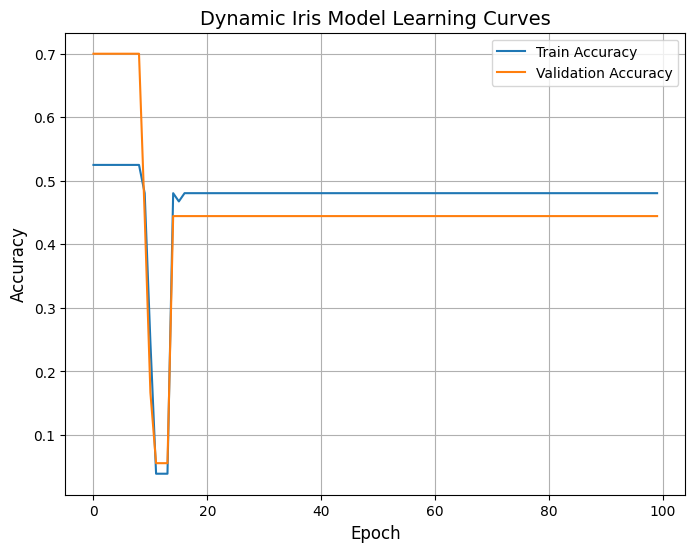

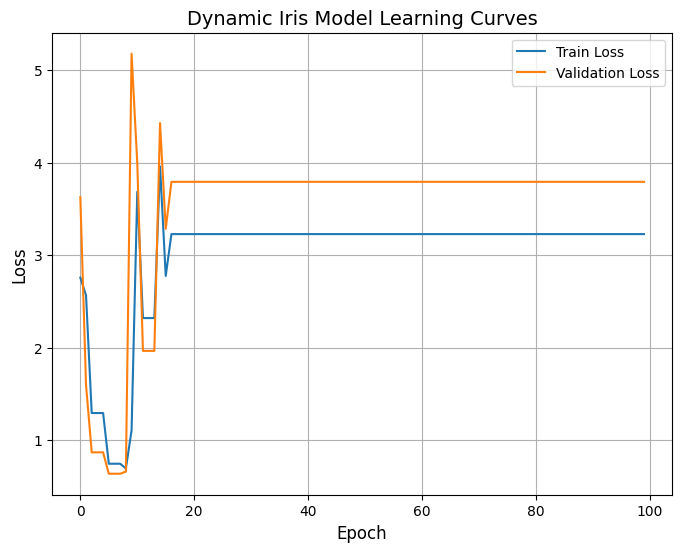

In [143]:
plot_learning_curves(train_acc_iris, test_acc_iris, train_losses_iris, val_losses_iris, title="Dynamic Iris Model Learning Curves")

In [ ]:
all_validation_iris = pd.concat(dfs_iris_all_validation, axis=0).sample(frac=1).reset_index(drop=True)
X_validation_dynamic = torch.tensor(all_validation.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_validation_dynamic = torch.tensor(all_validation['label'].values, dtype=torch.long).to(device)

all_test = pd.concat(dfs_iris_all_test, axis=0).sample(frac=1).reset_index(drop=True)
X_test_iris_dynamic = torch.tensor(all_test.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_test_iris_dynamic = torch.tensor(all_test['label'].values, dtype=torch.long).to(device)

model_iris_dynamic.eval()
with torch.no_grad():
    val_preds_dynamic_iris = model_iris_dynamic(X_validation_dynamic).argmax(dim=1)
    val_accuracy_dynamic_iris = accuracy_score(y_validation_dynamic.cpu(), val_preds_dynamic_iris.cpu())
    val_preds_baseline_iris = model_iris(X_val_iris).argmax(dim=1)
    val_accuracy_baseline_iris = accuracy_score(y_val_iris.cpu(), val_preds_baseline_iris.cpu())

    test_preds_dynamic_iris = model_iris_dynamic(X_test_iris_dynamic).argmax(dim=1)
    test_accuracy_dynamic_iris = accuracy_score(y_test_iris_dynamic.cpu(), test_preds_dynamic_iris.cpu())
    test_preds_baseline_iris = model_iris(X_test_iris).argmax(dim=1)
    test_accuracy_baseline_iris = accuracy_score(y_test_iris.cpu(), test_preds_baseline_iris.cpu())

    print("Classification Report for Dynamic Iris Model (Validation):")
    print(classification_report(y_validation_dynamic.cpu(), val_preds_dynamic_iris.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_iris))]))

    print("Classification Report for Baseline Iris Model (Validation):")
    print(classification_report(y_val_iris.cpu(), val_preds_baseline_iris.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_iris))]))

    print("Classification Report for Dynamic Iris Model (Test):")
    print(classification_report(y_test_iris_dynamic.cpu(), test_preds_dynamic_iris.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_iris))]))

    print("Classification Report for Baseline Iris Model (Test):")
    print(classification_report(y_test_iris.cpu(), test_preds_baseline_iris.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_iris))]))


print(f"Dynamic Iris Model Validation Accuracy: {val_accuracy_dynamic_iris:.4f}")
print(f"Dynamic Iris Model Test Accuracy: {test_accuracy_dynamic_iris:.4f}")
print(f"Baseline Iris Model Validation Accuracy: {val_accuracy_baseline_iris:.4f}")
print(f"Baseline Iris Model Test Accuracy: {test_accuracy_baseline_iris:.4f}")


### Evaluation of baseline models and dynamic models

In [ ]:
def train_until_goal_simple(X_train, y_train, X_validation, y_validation, optimal_params, goal_acc, epochs):
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train))
    hidden_layers = optimal_params['hidden_layers']
    activation = optimal_params['activation']

    model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=optimal_params['lr'])
    criterion = nn.CrossEntropyLoss()
    train_acc, test_acc, train_losses, test_losses = train_model(model, optimizer, criterion, X_train, y_train, X_validation, y_validation, epochs=epochs, goal_accuracy=goal_acc)
    return train_acc, test_acc

def train_until_goal_dynamic(X_train, dfs_all_train, dfs_all_validation, optimal_params, goal_acc, epochs):
    input_dim = X_train.shape[1]
    activation = optimal_params['activation']
    model= DynamicMLP(input_dim, max_layers=optimal_params['max_layers'], activation=activation).to(device)
    optimizer_dynamic = torch.optim.Adam(model.parameters(), lr=optimal_params['lr'])
    criterion = nn.CrossEntropyLoss()
    train_acc, test_acc, train_losses, val_losses = train_complex_model(model, optimizer_dynamic, criterion, optimal_params, dfs_all_train, dfs_all_validation, epochs=epochs, goal_accuracy=goal_acc)
    return train_acc, test_acc


In [ ]:
# percentages_of_data = list(range(10, 101, 5))


# results_fashion = []
# results_df_fashion = pd.DataFrame()
# for percent in percentages_of_data:
#     frac = percent / 100
#     dfs_all_train_sample = [df.sample(frac=frac, random_state=seed).reset_index(drop=True) for df in dfs_fashion_all_train]
#     dfs_all_validation_sample = [df.sample(frac=frac, random_state=seed).reset_index(drop=True) for df in dfs_fashion_all_validation]

#     df_all_train_combined = pd.concat(dfs_all_train_sample, axis=0).sample(frac=1).reset_index(drop=True)
#     df_all_validation_combined = pd.concat(dfs_all_validation_sample, axis=0).sample(frac=1).reset_index(drop=True)

#     df_all_train_combined['label'] = df_all_train_combined['label'].map(label_map_fashion)
#     df_all_validation_combined['label'] = df_all_validation_combined['label'].map(label_map_fashion)

#     X_train_fashion = torch.tensor(df_all_train_combined.drop(columns=['label']).values, dtype=torch.float32).to(device)
#     y_train_fashion = torch.tensor(df_all_train_combined['label'].values, dtype=torch.long).to(device)

#     X_validation_fashion = torch.tensor(df_all_validation_combined.drop(columns=['label']).values, dtype=torch.float32).to(device)
#     y_validation_fashion = torch.tensor(df_all_validation_combined['label'].values, dtype=torch.long).to(device)
#     print(f"\nData percentage: {percent}% - Training sizes: {X_train_fashion.shape[0]} train, {X_validation_fashion.shape[0]} validation")
#     train_acc_baseline, val_acc_baseline = train_until_goal_simple(X_train_fashion, y_train_fashion, X_validation_fashion, y_validation_fashion, optimal_params_fashion, goal_acc=0.85, epochs=300)
#     print(f"Baseline model reached {val_acc_baseline[-1]:.4f} accuracy after {len(val_acc_baseline)} epochs")
#     train_acc_dynamic, val_acc_dynamic = train_until_goal_dynamic(X_train_fashion, dfs_all_train_sample, dfs_all_validation_sample, optimal_params_fashion, goal_acc=0.85, epochs=3500)
#     print(f"Dynamic model reached {val_acc_dynamic[-1]:.4f} accuracy after {len(val_acc_dynamic)} epochs")

#     results_fashion.append({
#         'data_percentage': percent,
#         'baseline_epochs': len(val_acc_baseline),
#         'baseline_final_val_acc': val_acc_baseline[-1],
#         'dynamic_epochs': len(val_acc_dynamic),
#         'dynamic_final_val_acc': val_acc_dynamic[-1]
#     })

# results_df_fashion = pd.DataFrame(results_fashion)
# results_df_fashion.to_csv(os.path.join(results_dir, "data_efficiency_results_fashion.csv"), index=False)
# print("Data efficiency results saved to:", os.path.join(results_dir, "data_efficiency_results_fashion.csv"))

In [1]:
# Plot Baseline vs Dynamic Model Performance
def plot_baseline_vs_dynamic_comparison(results_df, dataset_name, save_dir, goal_acc):
    """
    Plot comparison between baseline and dynamic models
    
    Parameters:
    - results_df: DataFrame with columns ['data_percentage', 'baseline_epochs', 'baseline_final_val_acc', 'dynamic_epochs', 'dynamic_final_val_acc']
    - dataset_name: Name for the plots
    - save_dir: Directory to save plots
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'{dataset_name}: Baseline vs Dynamic Model Comparison', fontsize=16)
    
    # Plot 1: Final Validation Accuracy vs Data Percentage
    ax1.plot(results_df['data_percentage'], results_df['baseline_final_val_acc'], 
             'o-', label='Baseline Model', color='blue', linewidth=2, markersize=6)
    ax1.plot(results_df['data_percentage'], results_df['dynamic_final_val_acc'], 
             's-', label='Dynamic Model', color='red', linewidth=2, markersize=6)
    
    ax1.set_xlabel('Training Data Percentage (%)')
    ax1.set_ylabel('Final Validation Accuracy')
    ax1.set_title('Final Validation Accuracy vs Training Data Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(results_df['data_percentage'].min() - 2, results_df['data_percentage'].max() + 2)
    
    # Add goal accuracy line if available
    if 'goal_acc' in locals():
        ax1.axhline(y=goal_acc, color='green', linestyle='--', alpha=0.7, 
                    label=f'Goal Accuracy ({goal_acc:.2f})')
        ax1.legend()
    
    # Plot 2: Epochs Required vs Data Percentage
    ax2.plot(results_df['data_percentage'], results_df['baseline_epochs'], 
             'o-', label='Baseline Model', color='blue', linewidth=2, markersize=6)
    ax2.plot(results_df['data_percentage'], results_df['dynamic_epochs'], 
             's-', label='Dynamic Model', color='red', linewidth=2, markersize=6)
    
    ax2.set_xlabel('Training Data Percentage (%)')
    ax2.set_ylabel('Epochs Required')
    ax2.set_title('Training Epochs vs Training Data Size')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(results_df['data_percentage'].min() - 2, results_df['data_percentage'].max() + 2)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = os.path.join(save_dir, f'{dataset_name.lower()}_baseline_vs_dynamic_comparison.pdf')
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight', format='pdf')
    print(f"Comparison plot saved to: {plot_filename}")
    
    return fig

# Additional analysis plot: Efficiency comparison
def plot_efficiency_analysis(results_df, dataset_name, save_dir):
    """
    Plot efficiency analysis showing epoch differences and accuracy differences
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'{dataset_name}: Model Efficiency Analysis', fontsize=16)
    
    # Calculate differences
    epoch_diff = results_df['dynamic_epochs'] - results_df['baseline_epochs']
    acc_diff = results_df['dynamic_final_val_acc'] - results_df['baseline_final_val_acc']
    
    # Plot 1: Epoch Difference (Dynamic - Baseline)
    colors = ['red' if x > 0 else 'blue' for x in epoch_diff]
    bars1 = ax1.bar(results_df['data_percentage'], epoch_diff, color=colors, alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.set_xlabel('Training Data Percentage (%)')
    ax1.set_ylabel('Epoch Difference (Dynamic - Baseline)')
    ax1.set_title('Training Time Difference\n(Positive = Dynamic takes longer)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars1, epoch_diff):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + (5 if height > 0 else -5),
                f'{int(value)}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    # Plot 2: Accuracy Difference (Dynamic - Baseline)
    colors2 = ['green' if x > 0 else 'orange' for x in acc_diff]
    bars2 = ax2.bar(results_df['data_percentage'], acc_diff, color=colors2, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Training Data Percentage (%)')
    ax2.set_ylabel('Accuracy Difference (Dynamic - Baseline)')
    ax2.set_title('Final Accuracy Difference\n(Positive = Dynamic performs better)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars2, acc_diff):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.005 if height > 0 else -0.005),
                f'{value:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = os.path.join(save_dir, f'{dataset_name.lower()}_efficiency_analysis.pdf')
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight', format='pdf')
    print(f"Efficiency analysis plot saved to: {plot_filename}")
    
    return fig

# Summary statistics function
def print_comparison_summary(results_df, dataset_name):
    """Print summary statistics comparing baseline and dynamic models"""
    
    print(f"\n=== {dataset_name} Model Comparison Summary ===")
    
    # Overall performance
    baseline_avg_acc = results_df['baseline_final_val_acc'].mean()
    dynamic_avg_acc = results_df['dynamic_final_val_acc'].mean()
    baseline_avg_epochs = results_df['baseline_epochs'].mean()
    dynamic_avg_epochs = results_df['dynamic_epochs'].mean()
    
    print(f"Average Final Accuracy:")
    print(f"  Baseline: {baseline_avg_acc:.4f}")
    print(f"  Dynamic:  {dynamic_avg_acc:.4f}")
    print(f"  Difference: {dynamic_avg_acc - baseline_avg_acc:.4f} (Dynamic - Baseline)")
    
    print(f"\nAverage Training Epochs:")
    print(f"  Baseline: {baseline_avg_epochs:.1f}")
    print(f"  Dynamic:  {dynamic_avg_epochs:.1f}")
    print(f"  Difference: {dynamic_avg_epochs - baseline_avg_epochs:.1f} (Dynamic - Baseline)")
    
    # Best performance
    best_baseline_acc = results_df['baseline_final_val_acc'].max()
    best_dynamic_acc = results_df['dynamic_final_val_acc'].max()
    best_baseline_idx = results_df['baseline_final_val_acc'].idxmax()
    best_dynamic_idx = results_df['dynamic_final_val_acc'].idxmax()
    
    print(f"\nBest Performance:")
    print(f"  Baseline: {best_baseline_acc:.4f} at {results_df.loc[best_baseline_idx, 'data_percentage']}% data")
    print(f"  Dynamic:  {best_dynamic_acc:.4f} at {results_df.loc[best_dynamic_idx, 'data_percentage']}% data")
    
    # Data efficiency (performance at low data percentages)
    low_data_mask = results_df['data_percentage'] <= 30
    if low_data_mask.any():
        baseline_low_data = results_df[low_data_mask]['baseline_final_val_acc'].mean()
        dynamic_low_data = results_df[low_data_mask]['dynamic_final_val_acc'].mean()
        print(f"\nLow Data Performance (≤30% data):")
        print(f"  Baseline: {baseline_low_data:.4f}")
        print(f"  Dynamic:  {dynamic_low_data:.4f}")
        print(f"  Difference: {dynamic_low_data - baseline_low_data:.4f}")
    
    return {
        'avg_accuracy_diff': dynamic_avg_acc - baseline_avg_acc,
        'avg_epochs_diff': dynamic_avg_epochs - baseline_avg_epochs,
        'best_baseline': best_baseline_acc,
        'best_dynamic': best_dynamic_acc
    }

In [ ]:
# Example usage: Plot your Fashion-MNIST results
print("=== Plotting Fashion-MNIST Results ===")

# Assuming you have results_df_fashion from your code block
# If you don't have it yet, you can load it from CSV:
# results_df_fashion = pd.read_csv(os.path.join(results_dir, "data_efficiency_results_fashion.csv"))

# Check if results_df_fashion exists
if 'results_df_fashion' in locals() and not results_df_fashion.empty:
    print(f"Found Fashion-MNIST results with {len(results_df_fashion)} data points")
    
    # Plot the comparison
    comparison_fig = plot_baseline_vs_dynamic_comparison(results_df_fashion, 'Fashion-MNIST', results_dir)
    
    # Plot efficiency analysis
    efficiency_fig = plot_efficiency_analysis(results_df_fashion, 'Fashion-MNIST', results_dir)
    
    # Print summary statistics
    summary_stats = print_comparison_summary(results_df_fashion, 'Fashion-MNIST')
    
    # Display the results DataFrame
    print("\n=== Detailed Results ===")
    display(results_df_fashion)
    
    plt.show()

else:
    print("results_df_fashion not found. Please run your data collection code first.")
    print("The expected DataFrame structure should have columns:")
    print("['data_percentage', 'baseline_epochs', 'baseline_final_val_acc', 'dynamic_epochs', 'dynamic_final_val_acc']")
    
    # Create a sample for demonstration
    sample_data = {
        'data_percentage': list(range(10, 101, 5)),
        'baseline_epochs': [500 + i*2 for i in range(19)],  # Example data
        'baseline_final_val_acc': [0.7 + i*0.01 for i in range(19)],
        'dynamic_epochs': [600 + i*3 for i in range(19)],
        'dynamic_final_val_acc': [0.72 + i*0.008 for i in range(19)]
    }
    sample_df = pd.DataFrame(sample_data)
    
    print("\nDemo with sample data:")
    comparison_fig = plot_baseline_vs_dynamic_comparison(sample_df, 'Sample-Data', results_dir)
    efficiency_fig = plot_efficiency_analysis(sample_df, 'Sample-Data', results_dir)

In [ ]:
# Alternative: Load and plot existing results from CSV
def load_and_plot_results(csv_filename, dataset_name, results_dir):
    """
    Load results from CSV and create plots
    
    Parameters:
    - csv_filename: Name of the CSV file with results
    - dataset_name: Name for the plots
    - results_dir: Directory containing the CSV and where to save plots
    """
    try:
        csv_path = os.path.join(results_dir, csv_filename)
        results_df = pd.read_csv(csv_path)
        
        print(f"Loaded results from {csv_filename}")
        print(f"Data shape: {results_df.shape}")
        print(f"Columns: {list(results_df.columns)}")
        
        # Create plots
        comparison_fig = plot_baseline_vs_dynamic_comparison(results_df, dataset_name, results_dir)
        efficiency_fig = plot_efficiency_analysis(results_df, dataset_name, results_dir)
        
        # Print summary
        summary_stats = print_comparison_summary(results_df, dataset_name)
        
        return results_df
        
    except FileNotFoundError:
        print(f"File {csv_filename} not found in {results_dir}")
        return None
    except Exception as e:
        print(f"Error loading results: {e}")
        return None

# Load and plot Fashion-MNIST results if CSV exists
fashion_results = load_and_plot_results("data_efficiency_results_fashion.csv", "Fashion-MNIST", results_dir)

if fashion_results is not None:
    display(fashion_results.head(10))
else:
    print("No existing results found. Run your data collection code first.")

In [ ]:
# Quick plotting function for immediate use with your results_df_fashion
def quick_plot_results(results_df, title="Model Comparison"):
    """
    Quick plotting function for your results DataFrame
    """
    if results_df.empty:
        print("DataFrame is empty!")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot 1: Accuracies
    ax1.plot(results_df['data_percentage'], results_df['baseline_final_val_acc'], 
             'o-', label='Baseline Model', color='blue', linewidth=2, markersize=8)
    ax1.plot(results_df['data_percentage'], results_df['dynamic_final_val_acc'], 
             's-', label='Dynamic Model', color='red', linewidth=2, markersize=8)
    ax1.set_xlabel('Training Data Percentage (%)', fontsize=12)
    ax1.set_ylabel('Final Validation Accuracy', fontsize=12)
    ax1.set_title('Accuracy vs Training Data Size', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Add goal line if it was 0.85
    ax1.axhline(y=0.85, color='green', linestyle='--', alpha=0.7, label='Goal (0.85)')
    ax1.legend(fontsize=11)
    
    # Plot 2: Epochs
    ax2.plot(results_df['data_percentage'], results_df['baseline_epochs'], 
             'o-', label='Baseline Model', color='blue', linewidth=2, markersize=8)
    ax2.plot(results_df['data_percentage'], results_df['dynamic_epochs'], 
             's-', label='Dynamic Model', color='red', linewidth=2, markersize=8)
    ax2.set_xlabel('Training Data Percentage (%)', fontsize=12)
    ax2.set_ylabel('Epochs Required', fontsize=12)
    ax2.set_title('Training Time vs Training Data Size', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(results_dir, f'{title.lower().replace(" ", "_")}_quick_plot.pdf')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', format='pdf')
    print(f"Quick plot saved to: {plot_path}")
    
    plt.show()
    
    # Print quick summary
    print(f"\n=== Quick Summary ===")
    print(f"Data points: {len(results_df)}")
    print(f"Data range: {results_df['data_percentage'].min()}% to {results_df['data_percentage'].max()}%")
    print(f"Baseline accuracy range: {results_df['baseline_final_val_acc'].min():.3f} - {results_df['baseline_final_val_acc'].max():.3f}")
    print(f"Dynamic accuracy range: {results_df['dynamic_final_val_acc'].min():.3f} - {results_df['dynamic_final_val_acc'].max():.3f}")
    print(f"Baseline epochs range: {results_df['baseline_epochs'].min()} - {results_df['baseline_epochs'].max()}")
    print(f"Dynamic epochs range: {results_df['dynamic_epochs'].min()} - {results_df['dynamic_epochs'].max()}")

# If you have your results_df_fashion, use this:
if 'results_df_fashion' in locals() and not results_df_fashion.empty:
    quick_plot_results(results_df_fashion, "Fashion-MNIST: Baseline vs Dynamic")
else:
    print("results_df_fashion not available. Run your data collection code first.")

In [ ]:
def get_new_all_train_val_test(rseed):
    dfs_train_new = []
    dfs_val_new = []
    dfs_test_new = []
    swap_frac = 0.2

    # Copy to avoid modifying originals
    dfs_train_copy = [df.copy() for df in dfs_fashion_all_train]
    dfs_val_copy = [df.copy() for df in dfs_fashion_all_validation]
    dfs_test_copy = [df.copy() for df in dfs_fashion_all_test]

    for i in range(len(dfs_train_copy)):
        train_df = dfs_train_copy[i]
        val_df = dfs_val_copy[i]
        test_df = dfs_test_copy[i]

        # Sample 20% from each
        train_swap = train_df.sample(frac=swap_frac, random_state=rseed)
        val_swap = val_df.sample(frac=swap_frac, random_state=rseed)
        test_swap = test_df.sample(frac=swap_frac, random_state=rseed)

        # Remove swapped rows from original
        train_remain = train_df.drop(train_swap.index)
        val_remain = val_df.drop(val_swap.index)
        test_remain = test_df.drop(test_swap.index)

        # Swap: rotate swaps among train, val, test
        new_train = pd.concat([train_remain, val_swap], axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)
        new_val = pd.concat([val_remain, test_swap], axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)
        new_test = pd.concat([test_remain, train_swap], axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)

        dfs_train_new.append(new_train)
        dfs_val_new.append(new_val)
        dfs_test_new.append(new_test)
        
    return dfs_train_new, dfs_val_new, dfs_test_new

def get_new_all_train_val_test_iris(rseed):
        dfs_train_new = []
        dfs_val_new = []
        dfs_test_new = []
        swap_frac = 0.2

        dfs_train_copy = [df.copy() for df in dfs_iris_all_train]
        dfs_val_copy = [df.copy() for df in dfs_iris_all_validation]
        dfs_test_copy = [df.copy() for df in dfs_iris_all_test]

        for i in range(len(dfs_train_copy)):
            train_df = dfs_train_copy[i]
            val_df = dfs_val_copy[i]
            test_df = dfs_test_copy[i]

            train_swap = train_df.sample(frac=swap_frac, random_state=rseed)
            val_swap = val_df.sample(frac=swap_frac, random_state=rseed)
            test_swap = test_df.sample(frac=swap_frac, random_state=rseed)

            train_remain = train_df.drop(train_swap.index)
            val_remain = val_df.drop(val_swap.index)
            test_remain = test_df.drop(test_swap.index)

            new_train = pd.concat([train_remain, val_swap], axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)
            new_val = pd.concat([val_remain, test_swap], axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)
            new_test = pd.concat([test_remain, train_swap], axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)

            dfs_train_new.append(new_train)
            dfs_val_new.append(new_val)
            dfs_test_new.append(new_test)

        return dfs_train_new, dfs_val_new, dfs_test_new

     
     

In [ ]:
def get_new_data(rseed, fashion=True, debug=False):  
    if fashion:  
        dfs_train_new, dfs_val_new, dfs_test_new = get_new_all_train_val_test(rseed)
    else:
        dfs_train_new, dfs_val_new, dfs_test_new = get_new_all_train_val_test_iris(rseed)
    # Concatenate all class DataFrames for train/val/test and shuffle
    df_train_concat = pd.concat(dfs_train_new, axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)
    df_validation_concat = pd.concat(dfs_val_new, axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)
    df_test_concat = pd.concat(dfs_test_new, axis=0).sample(frac=1, random_state=rseed).reset_index(drop=True)

    X_train_new = torch.tensor(df_train_concat.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_train_new = torch.tensor(df_train_concat['label'].values, dtype=torch.long).to(device)

    X_validation_new = torch.tensor(df_validation_concat.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_validation_new = torch.tensor(df_validation_concat['label'].values, dtype=torch.long).to(device)

    X_test_new = torch.tensor(df_test_concat.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_test_new = torch.tensor(df_test_concat['label'].values, dtype=torch.long).to(device)

    return dfs_train_new, dfs_val_new, dfs_test_new, X_train_new, y_train_new, X_validation_new, y_validation_new, X_test_new, y_test_new



In [ ]:
cv_results = []
runs = 1


for k in tqdm(range(runs),  desc="Cross Validation Progress"):
    dfs_train, dfs_val, dfs_test, X_train, y_train, X_val, y_val, X_test, y_test = get_new_data(rseed=seed + k)
    
    # Simple model
    start_time = time.time()
    input_dim_fashion = X_train.shape[1]
    output_dim_fashion = len(torch.unique(y_train))
    hidden_layers_fashion = optimal_params_fashion['hidden_layers']
    activation_fashion = optimal_params_fashion['activation']

    model_fashion = SimpleMLP(input_dim_fashion, hidden_layers_fashion, output_dim_fashion, activation_fashion).to(device)
    optimizer_fashion = torch.optim.Adam(model_fashion.parameters(), lr=optimal_params_fashion['lr'])
    criterion = nn.CrossEntropyLoss()
    train_acc, test_acc, train_losses, test_losses = train_model(model_fashion, optimizer_fashion, criterion, X_train, y_train, X_val, y_val, epochs=350)
    elapsed_simple = time.time() - start_time


    # Dynamic model
    start_time = time.time()
    input_dim_fashion = X_train_fashion.shape[1]
    activation_fashion = optimal_params_fashion_dynamic['activation']
    model_fashion_dynamic = DynamicMLP(input_dim_fashion, max_layers=3).to(device)
    optimizer_fashion_dynamic = torch.optim.Adam(model_fashion_dynamic.parameters(), lr=optimal_params_fashion_dynamic['lr'])
    criterion = nn.CrossEntropyLoss()
    train_acc, test_acc, train_losses, val_losses = train_complex_model(model_fashion_dynamic, optimizer_fashion_dynamic, criterion, optimal_params_fashion_dynamic, dfs_train, dfs_val, epochs=1000)


    all_validation  = pd.concat(dfs_val, axis=0).sample(frac=1).reset_index(drop=True)
    X_validation_dynamic = torch.tensor(all_validation.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_validation_dynamic = torch.tensor(all_validation['label'].values, dtype=torch.long).to(device)

    all_test = pd.concat(dfs_test, axis=0).sample(frac=1).reset_index(drop=True)
    X_test_fashion_dynamic = torch.tensor(all_test.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_test_fashion_dynamic = torch.tensor(all_test['label'].values, dtype=torch.long).to(device)

    model_fashion_dynamic.eval()
    with torch.no_grad():
        # Dynamic model metrics
        val_preds_dynamic_fashion = model_fashion_dynamic(X_validation_dynamic).argmax(dim=1)
        val_accuracy_dynamic_fashion = accuracy_score(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu())
        recall_dynamic = recall_score(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu(), average='macro')
        precision_dynamic = precision_score(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu(), average='macro')
        f1_dynamic = f1_score(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu(), average='macro')

        test_preds_dynamic_fashion = model_fashion_dynamic(X_test_fashion_dynamic).argmax(dim=1)
        test_accuracy_dynamic_fashion = accuracy_score(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu())
        recall_dynamic_test = recall_score(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu(), average='macro')
        precision_dynamic_test = precision_score(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu(), average='macro')
        f1_dynamic_test = f1_score(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu(), average='macro')

        # Training metrics for dynamic model
        train_preds_dynamic_fashion = model_fashion_dynamic(X_train).argmax(dim=1)
        train_accuracy_dynamic_fashion = accuracy_score(y_train.cpu(), train_preds_dynamic_fashion.cpu())
        recall_dynamic_train = recall_score(y_train.cpu(), train_preds_dynamic_fashion.cpu(), average='macro')
        precision_dynamic_train = precision_score(y_train.cpu(), train_preds_dynamic_fashion.cpu(), average='macro')
        f1_dynamic_train = f1_score(y_train.cpu(), train_preds_dynamic_fashion.cpu(), average='macro')

        elapsed_dynamic = time.time() - start_time

        # Baseline (simple) model metrics
        val_preds_baseline_fashion = model_fashion(X_val).argmax(dim=1)
        val_accuracy_baseline_fashion = accuracy_score(y_val.cpu(), val_preds_baseline_fashion.cpu())
        recall_simple = recall_score(y_val.cpu(), val_preds_baseline_fashion.cpu(), average='macro')
        precision_simple = precision_score(y_val.cpu(), val_preds_baseline_fashion.cpu(), average='macro')
        f1_simple = f1_score(y_val.cpu(), val_preds_baseline_fashion.cpu(), average='macro')

        test_preds_baseline_fashion = model_fashion(X_test).argmax(dim=1)
        test_accuracy_baseline_fashion = accuracy_score(y_test.cpu(), test_preds_baseline_fashion.cpu())
        recall_simple_test = recall_score(y_test.cpu(), test_preds_baseline_fashion.cpu(), average='macro')
        precision_simple_test = precision_score(y_test.cpu(), test_preds_baseline_fashion.cpu(), average='macro')
        f1_simple_test = f1_score(y_test.cpu(), test_preds_baseline_fashion.cpu(), average='macro')

        # Training metrics for simple model
        train_preds_baseline_fashion = model_fashion(X_train).argmax(dim=1)
        train_accuracy_baseline_fashion = accuracy_score(y_train.cpu(), train_preds_baseline_fashion.cpu())
        recall_simple_train = recall_score(y_train.cpu(), train_preds_baseline_fashion.cpu(), average='macro')
        precision_simple_train = precision_score(y_train.cpu(), train_preds_baseline_fashion.cpu(), average='macro')
        f1_simple_train = f1_score(y_train.cpu(), train_preds_baseline_fashion.cpu(), average='macro')

    print(f"Seed: {seed + k} | Simple: {elapsed_simple:.2f}s, Val Acc: {val_accuracy_baseline_fashion:.4f}, Test Acc: {test_accuracy_baseline_fashion:.4f}, "
          f"Val Recall: {recall_simple:.4f}, Test Recall: {recall_simple_test:.4f}, "
          f"Val Precision: {precision_simple:.4f}, Test Precision: {precision_simple_test:.4f}, "
          f"Val F1: {f1_simple:.4f}, Test F1: {f1_simple_test:.4f} | "
          f"Dynamic: {elapsed_dynamic:.2f}s, Val Acc: {val_accuracy_dynamic_fashion:.4f}, Test Acc: {test_accuracy_dynamic_fashion:.4f}, "
          f"Val Recall: {recall_dynamic:.4f}, Test Recall: {recall_dynamic_test:.4f}, "
          f"Val Precision: {precision_dynamic:.4f}, Test Precision: {precision_dynamic_test:.4f}, "
          f"Val F1: {f1_dynamic:.4f}, Test F1: {f1_dynamic_test:.4f}")

    cv_results.append({
        'fold': k,
        'simple_time': elapsed_simple,
        'simple_train_acc': train_accuracy_baseline_fashion,
        'simple_train_recall': recall_simple_train,
        'simple_train_precision': precision_simple_train,
        'simple_train_f1': f1_simple_train,
        'simple_val_acc': val_accuracy_baseline_fashion,
        'simple_test_acc': test_accuracy_baseline_fashion,
        'simple_val_recall': recall_simple,
        'simple_test_recall': recall_simple_test,
        'simple_val_precision': precision_simple,
        'simple_test_precision': precision_simple_test,
        'simple_val_f1': f1_simple,
        'simple_test_f1': f1_simple_test,
        'dynamic_time': elapsed_dynamic,
        'dynamic_train_acc': train_accuracy_dynamic_fashion,
        'dynamic_train_recall': recall_dynamic_train,
        'dynamic_train_precision': precision_dynamic_train,
        'dynamic_train_f1': f1_dynamic_train,
        'dynamic_val_acc': val_accuracy_dynamic_fashion,
        'dynamic_test_acc': test_accuracy_dynamic_fashion,
        'dynamic_val_recall': recall_dynamic,
        'dynamic_test_recall': recall_dynamic_test,
        'dynamic_val_precision': precision_dynamic,
        'dynamic_test_precision': precision_dynamic_test,
        'dynamic_val_f1': f1_dynamic,
        'dynamic_test_f1': f1_dynamic_test
    })

In [ ]:
cv_results_iris = []
runs = 1

for k in tqdm(range(runs), desc="Cross Validation Progress (Iris)"):
    dfs_train, dfs_val, dfs_test, X_train, y_train, X_val, y_val, X_test, y_test = get_new_data(rseed=seed + k)
    
    # Simple model for Iris
    start_time = time.time()
    input_dim_iris = X_train.shape[1]
    output_dim_iris = len(torch.unique(y_train))
    hidden_layers_iris = optimal_params_iris['hidden_layers']
    activation_iris = optimal_params_iris['activation']

    model_iris = SimpleMLP(input_dim_iris, hidden_layers_iris, output_dim_iris, activation_iris).to(device)
    optimizer_iris = torch.optim.Adam(model_iris.parameters(), lr=optimal_params_iris['lr'])
    criterion = nn.CrossEntropyLoss()
    train_acc, test_acc, train_losses, test_losses = train_model(model_iris, optimizer_iris, criterion, X_train, y_train, X_val, y_val, epochs=150)
    elapsed_simple = time.time() - start_time

    # Dynamic model for Iris
    start_time = time.time()
    input_dim_iris = X_train.shape[1]
    activation_iris = optimal_params_iris_dynamic['activation']
    model_iris_dynamic = DynamicMLP(input_dim_iris, max_layers=1).to(device)
    optimizer_iris_dynamic = torch.optim.Adam(model_iris_dynamic.parameters(), lr=optimal_params_iris_dynamic['lr'])
    criterion = nn.CrossEntropyLoss()
    train_acc, test_acc, train_losses, val_losses = train_complex_model(model_iris_dynamic, optimizer_iris_dynamic, criterion, optimal_params_iris_dynamic, dfs_train, dfs_val, epochs=100)

    all_validation = pd.concat(dfs_val, axis=0).sample(frac=1).reset_index(drop=True)
    X_validation_dynamic = torch.tensor(all_validation.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_validation_dynamic = torch.tensor(all_validation['label'].values, dtype=torch.long).to(device)

    all_test = pd.concat(dfs_test, axis=0).sample(frac=1).reset_index(drop=True)
    X_test_iris_dynamic = torch.tensor(all_test.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_test_iris_dynamic = torch.tensor(all_test['label'].values, dtype=torch.long).to(device)

    model_iris_dynamic.eval()
    with torch.no_grad():
        val_preds_dynamic_iris = model_iris_dynamic(X_validation_dynamic).argmax(dim=1)
        val_accuracy_dynamic_iris = accuracy_score(y_validation_dynamic.cpu(), val_preds_dynamic_iris.cpu())
        val_preds_baseline_iris = model_iris(X_val).argmax(dim=1)
        val_accuracy_baseline_iris = accuracy_score(y_val.cpu(), val_preds_baseline_iris.cpu())

        test_preds_dynamic_iris = model_iris_dynamic(X_test_iris_dynamic).argmax(dim=1)
        test_accuracy_dynamic_iris = accuracy_score(y_test_iris_dynamic.cpu(), test_preds_dynamic_iris.cpu())
        test_preds_baseline_iris = model_iris(X_test).argmax(dim=1)
        test_accuracy_baseline_iris = accuracy_score(y_test.cpu(), test_preds_baseline_iris.cpu())

        # Baseline (simple) model metrics
        acc_simple = val_accuracy_baseline_iris
        recall_simple = recall_score(y_val.cpu(), val_preds_baseline_iris.cpu(), average='macro')
        precision_simple = precision_score(y_val.cpu(), val_preds_baseline_iris.cpu(), average='macro')
        f1_simple = f1_score(y_val.cpu(), val_preds_baseline_iris.cpu(), average='macro')

        # Dynamic model metrics
        elapsed_dynamic = time.time() - start_time
        acc_dyn = val_accuracy_dynamic_iris
        recall_dyn = recall_score(y_validation_dynamic.cpu(), val_preds_dynamic_iris.cpu(), average='macro')
        precision_dyn = precision_score(y_validation_dynamic.cpu(), val_preds_dynamic_iris.cpu(), average='macro')
        f1_dyn = f1_score(y_validation_dynamic.cpu(), val_preds_dynamic_iris.cpu(), average='macro')

        # Training metrics for validation set
        recall_train_simple = recall_score(y_train.cpu(), model_iris(X_train).argmax(dim=1).cpu(), average='macro')
        precision_train_simple = precision_score(y_train.cpu(), model_iris(X_train).argmax(dim=1).cpu(), average='macro')
        f1_train_simple = f1_score(y_train.cpu(), model_iris(X_train).argmax(dim=1).cpu(), average='macro')

        recall_train_dyn = recall_score(y_train.cpu(), model_iris_dynamic(X_train).argmax(dim=1).cpu(), average='macro')
        precision_train_dyn = precision_score(y_train.cpu(), model_iris_dynamic(X_train).argmax(dim=1).cpu(), average='macro')
        f1_train_dyn = f1_score(y_train.cpu(), model_iris_dynamic(X_train).argmax(dim=1).cpu(), average='macro')
    
    print(f"Seed: {seed + k} | Elapsed: {elapsed_simple:.2f}s, Simple Acc: {acc_simple:.4f}, Recall: {recall_simple:.4f}, Precision: {precision_simple:.4f}, F1: {f1_simple:.4f} | Elapsed: {elapsed_dynamic:.2f}s, Dynamic Acc: {acc_dyn:.4f}, Recall: {recall_dyn:.4f}, Precision: {precision_dyn:.4f}, F1: {f1_dyn:.4f}")
    cv_results_iris.append({
        'fold': k,
        'simple_time': elapsed_simple,
        'simple_val_acc': val_accuracy_baseline_iris,
        'simple_test_acc': test_accuracy_baseline_iris,
        'simple_train_acc': acc_simple,
        'simple_train_recall': recall_train_simple,
        'simple_train_precision': precision_train_simple,
        'simple_train_f1': f1_train_simple,
        'simple_val_recall': recall_simple,
        'simple_val_precision': precision_simple,
        'simple_val_f1': f1_simple,
        'simple_test_recall': recall_score(y_test.cpu(), test_preds_baseline_iris.cpu(), average='macro'),
        'simple_test_precision': precision_score(y_test.cpu(), test_preds_baseline_iris.cpu(), average='macro'),
        'simple_test_f1': f1_score(y_test.cpu(), test_preds_baseline_iris.cpu(), average='macro'),
        'dynamic_time': elapsed_dynamic,
        'dynamic_val_acc': val_accuracy_dynamic_iris,
        'dynamic_test_acc': test_accuracy_dynamic_iris,
        'dynamic_train_acc': acc_dyn,
        'dynamic_train_recall': recall_train_dyn,
        'dynamic_train_precision': precision_train_dyn,
        'dynamic_train_f1': f1_train_dyn,
        'dynamic_val_recall': recall_dyn,
        'dynamic_val_precision': precision_dyn,
        'dynamic_val_f1': f1_dyn,        
        'dynamic_test_recall': recall_score(y_test_iris_dynamic.cpu(), test_preds_dynamic_iris.cpu(), average='macro'),
        'dynamic_test_precision': precision_score(y_test_iris_dynamic.cpu(), test_preds_dynamic_iris.cpu(), average='macro'),
        'dynamic_test_f1': f1_score(y_test_iris_dynamic.cpu(), test_preds_dynamic_iris.cpu(), average='macro')
    })